# Limpieza y Análisis de URLs Legítimas - Sector Cripto

Este notebook contiene el análisis exploratorio y la limpieza inicial del dataset consolidado de URLs legítimas del sector cripto.

## Objetivos

- Evaluar la calidad y cantidad de los datos crudos.  
- Identificar valores nulos, duplicados y otras inconsistencias en las columnas principales.  
- Filtrar filas sin URLs válidas para obtener un dataset limpio y útil para modelado.  
- Integrar la tabla maestra de empresas para una distribución completa.  
- Documentar cada paso para facilitar la comprensión y reproducibilidad.


In [14]:
import pandas as pd
import os

# Ruta local donde tienes los datos en crudo
base_path = '/Users/test/Desktop/phishing-detector/data/raw/legitimas'

# Nombre del archivo crudo de cripto
archivo_cripto = 'cripto_legitimas_crudo.csv'

# Ruta completa al archivo
ruta_archivo = os.path.join(base_path, archivo_cripto)

# Cargar CSV
df_cripto = pd.read_csv(ruta_archivo)

# Información general del DataFrame
print("Información del DataFrame:")
print(df_cripto.info())

# Conteo total y duplicados
total_filas = len(df_cripto)
duplicados = df_cripto.duplicated().sum()
print(f"\nTotal filas: {total_filas}")
print(f"Duplicados: {duplicados} ({(duplicados / total_filas) * 100:.2f}%)")

# Valores nulos por columna
print("\nValores nulos por columna:")
print(df_cripto.isnull().sum())

# Mostrar primeras filas para inspección visual
print("\nPrimeras filas del DataFrame:")
display(df_cripto.head())


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   empresa  209 non-null    object
 1   url      207 non-null    object
 2   fecha    209 non-null    object
 3   estado   209 non-null    object
dtypes: object(4)
memory usage: 6.7+ KB
None

Total filas: 209
Duplicados: 0 (0.00%)

Valores nulos por columna:
empresa    0
url        2
fecha      0
estado     0
dtype: int64

Primeras filas del DataFrame:


,empresa,url,fecha,estado
0,Binance,NaN,22/07/2025,OK
1,Coinbase,NaN,22/07/2025,OK
2,Kraken,https://www.kraken.com/,22/07/2025,OK
3,Bit2Me,https://bit2me.com/buy-axie-infinity,22/07/2025,OK
4,Bit2Me,https://bit2me.com/suite/custody,22/07/2025,OK


In [16]:
# Filtrar filas con URL no nula en el dataset cripto
df_cripto_limpio = df_cripto[df_cripto['url'].notna()].copy()

# Mostrar cuántas filas quedan tras eliminar URLs nulas
print(f"Filas tras filtrar URLs nulas: {len(df_cripto_limpio)}")



Filas tras filtrar URLs nulas: 207


In [17]:
import validators  # Librería para validar URLs

# Función para validar URLs: devuelve True si la URL es válida, False si no
def es_url_valida(url):
    if pd.isna(url):
        return False
    return validators.url(url)

# Crear nueva columna 'url_valida' aplicando la función a la columna 'url'
df_cripto_limpio['url_valida'] = df_cripto_limpio['url'].apply(es_url_valida)

# Resumen de validación de URLs
total_urls = len(df_cripto_limpio)
urls_validas = df_cripto_limpio['url_valida'].sum()
urls_invalidas = total_urls - urls_validas

print(f"Total URLs: {total_urls}")
print(f"URLs válidas: {urls_validas} ({urls_validas / total_urls * 100:.2f}%)")
print(f"URLs inválidas: {urls_invalidas} ({urls_invalidas / total_urls * 100:.2f}%)")

# Mostrar algunos ejemplos de URLs inválidas para inspección
print("\nEjemplos de URLs inválidas:")
print(df_cripto_limpio.loc[~df_cripto_limpio['url_valida'], 'url'].head(10))


Total URLs: 207
URLs válidas: 207 (100.00%)
URLs inválidas: 0 (0.00%)

Ejemplos de URLs inválidas:
Series([], Name: url, dtype: object)


Distribución de URLs incluyendo empresas no representadas:
empresa
BINANCE       0
COINBASE      0
KRAKEN        1
BITFINEX      0
BITSTAMP      0
GEMINI        0
HUOBI         0
OKEX          0
BITTREX       0
POLONIEX      0
ETORO        96
BIT2ME      110
Name: count, dtype: int64


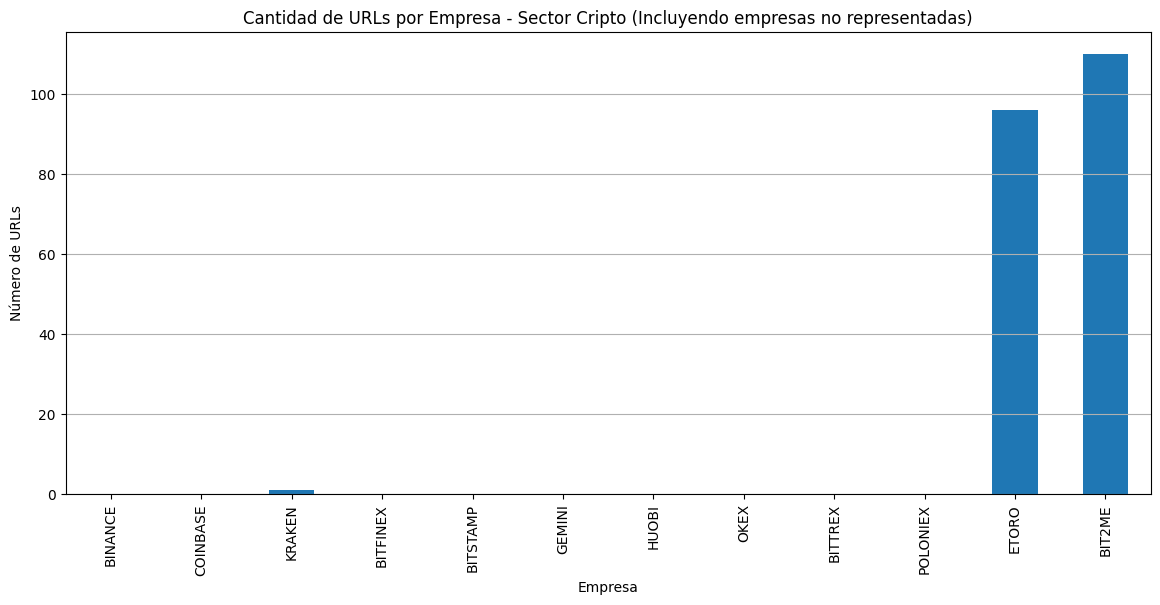

In [22]:
import matplotlib.pyplot as plt

# Lista completa de empresas objetivo para el sector Cripto (según tu tabla maestra)
cripto_objetivo = [
    'BINANCE', 'COINBASE', 'KRAKEN', 'BITFINEX', 'BITSTAMP',
    'GEMINI', 'HUOBI', 'OKEX', 'BITTREX', 'POLONIEX', 'ETORO', 'BIT2ME'
]

# Normalizamos la lista para asegurar coincidencias
cripto_objetivo = [e.upper() for e in cripto_objetivo]

# Normalizamos la columna 'empresa' para evitar discrepancias
df_cripto_limpio['empresa'] = df_cripto_limpio['empresa'].str.upper().str.strip()

# Contamos URLs por empresa en el dataset
urls_por_empresa = df_cripto_limpio['empresa'].value_counts()

# Reindexamos para que aparezcan todas las empresas, rellenando con 0 donde no haya datos
urls_por_empresa = urls_por_empresa.reindex(cripto_objetivo, fill_value=0)

print("Distribución de URLs incluyendo empresas no representadas:")
print(urls_por_empresa)

# Graficar distribución completa
plt.figure(figsize=(14,6))
urls_por_empresa.plot(kind='bar')
plt.title('Cantidad de URLs por Empresa - Sector Cripto (Incluyendo empresas no representadas)')
plt.xlabel('Empresa')
plt.ylabel('Número de URLs')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


In [23]:
# Seleccionar columnas relevantes para el modelo
# En cripto usamos 'empresa' en lugar de 'banco'
columnas_relevantes = ['empresa', 'url']

# Crear DataFrame limpio con solo las columnas seleccionadas
df_modelo = df_cripto_limpio[columnas_relevantes].copy()

# Eliminar filas duplicadas basadas en las columnas seleccionadas
df_modelo = df_modelo.drop_duplicates()

print(f"Filas después de limpiar duplicados en columnas relevantes: {len(df_modelo)}")

# Construir ruta para guardar en /data/processed/legitimas/
ruta_guardado = '/Users/test/Desktop/phishing-detector/data/processed/legitimas/cripto_legitimas_limpio.csv'

# Guardar CSV sin índice
df_modelo.to_csv(ruta_guardado, index=False)

print(f"Dataset limpio guardado en: {ruta_guardado}")


Filas después de limpiar duplicados en columnas relevantes: 207
Dataset limpio guardado en: /Users/test/Desktop/phishing-detector/data/processed/legitimas/cripto_legitimas_limpio.csv
